In [1]:
from __future__ import absolute_import, division, print_function

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import scipy
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os

from mlxtend.data import loadlocal_mnist
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

print(tf.__version__)

Using TensorFlow backend.


1.13.1


In [2]:
def plot_history(histories, key='acc'):
    """
     Args:
         histories: list of tuples. Each tuple is composed by a string (name of the model) and the history (output of
                    model.fit())
                    e.g. histories = [('CNN_classifier', history)]
         key: string, key for the metric to visulize. e.g. 'acc' for accuracy
     Return:
         it plots the training and the validation accuracy during the training
     """
    plt.figure(figsize=(16, 10))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_' + key],
                       '--', label=name.title() + ' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title() + ' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_', ' ').title())
    plt.legend()

    plt.xlim([0, max(history.epoch)])
    plt.show()

In [3]:
def plot_images(images, labels, class_names, predictions=None):
    """
    Args:
        images: numpy tensor containing 9 test images
                [image_num, height, width, channels]
        labels: list of int, dataset labels of 9 examples (sparse representation)
        class_names: list of string, name assicuated to each class
        predictions: output of the model on 9 images from the dataset (contains the class PDF for each image)
    Return:
        It plots the provided 9 images with the label from the dataset,
        eventually with the model predictions
    """
    print(images.shape)
    assert len(images) == len(labels) == 9
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        # Plot image.
#         img = images[i].reshape(28,28)
        ax.imshow(images[i].squeeze(), cmap='binary')
        # Show true and predicted classes.
        if predictions is None:
            xlabel = "True: {}".format(class_names[labels[i]])
        else:
            predictions_in = np.argmax(predictions, axis=1)
            xlabel = "True: {}, Pred: {}".format(class_names[labels[i]], class_names[predictions_in[i]])
        ax.set_xlabel(xlabel)
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [4]:
def plot_image(i, predictions, labels, images, class_names):
    """
    Args:
        i: int, index of the selected image in the dataset
        predictions: output of the model on the whole dataset (contains the class PDF for each image)
        labels: list of int, dataset labels (sparse representation)
        images: numpy tensor containing the test images
               [image_num, height, width, channels]
        class_names: list of string, name assicuated to each class
    Return:
        it plots the selected image with the label and the predicted class
    """
    predictions_array, true_label, img = predictions[i], labels[i], images[i]

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
#     img.reshape(28,28)
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100 * np.max(predictions_array),
                                         class_names[true_label]),
               color=color)

In [5]:
def plot_example_errors(model, images, labels, class_names):
    """
    Args:
        model: Keras model, already trained
        images: numpy tensor containing the test images
               [image_num, height, width, channels]
        labels: list of int, dataset labels (sparse representation)
        class_names: list of string, name assicuated to each class
    Return:
        It prints the confusion matrix
    """
    # Get the predicted classifications for the test-set.
    predictions = model.predict(images)

    predictions_in = np.argmax(predictions, axis=1)
    correct = (predictions_in == labels)

    # Negate the boolean array.
    incorrect = (correct == False)
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = images[incorrect]
    # Get the predicted classes for those images.
    cls_pred = predictions[incorrect]
    # Get the true classes for those images.
    cls_true = labels[incorrect]
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                labels=cls_true[0:9],
                class_names = class_names,
                predictions=cls_pred[0:9])

In [6]:
def plot_value_array(i, predictions, labels, num_classes):
    """
    Args:
        i: int, index of the selected image in the dataset
        predictions: output of the model on the whole dataset (contains the class PDF for each image)
        labels: list of int, dataset labels (sparse representation)
        num_classes: int, number of classes
    Return:
        it plots the class PDF
    """
    predictions_array, true_label = predictions[i], labels[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(num_classes), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [7]:
def image_with_PDF(images, labels, predictions, num_classes, class_names):
    """
    Args:
        images: numpy tensor containing the test images
                [image_num, height, width, channels]
        labels: list of int, labels related to 'images' (sparse representation)
        predictions: output of the model on 'images' (contains the class PDF for each image)
        num_classes: int, number of classes
        class_names: list of string, name assicuated to each class
    Return:
        It plots 15 images with the label from the dataset,
        the model prediction and the predicted PDF
    """

    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(num_images):
      plt.subplot(num_rows, 2*num_cols, 2*i+1)
      plot_image(i, predictions, labels, np.squeeze(images), class_names)
      plt.subplot(num_rows, 2*num_cols, 2*i+2)
      plot_value_array(i, predictions, labels, num_classes)
    plt.show()

In [34]:
def load_dataset():
    """
    Args:
        folder: string, path to the folder containing the downloaded datasets
    Return:
        train_images, test_images: numpy tensors containing
                the training and test images
                [image_num, height, width, channels]
        train_labels, test_labels: list of int, they containing the correct class indices for
                                    each of the images in train_images, test_images
    """
    # EMNIST byclass
    img_shape = 28 # size of the MNIST images
    
    temp_train_images, temp_train_labels = loadlocal_mnist(
        images_path='emnist-byclass-train-images-idx3-ubyte', 
        labels_path='emnist-byclass-train-labels-idx1-ubyte')
    
    temp_test_images, temp_test_labels = loadlocal_mnist(
        images_path='emnist-byclass-test-images-idx3-ubyte', 
        labels_path='emnist-byclass-test-labels-idx1-ubyte')
    
    ims = []
    labs = []
    
    train_index = []
    counter = 0
    print('Dimensions: %s' % (temp_train_images.shape[0]))
    for i in range(temp_train_images.shape[0]):
        if ((temp_train_labels[i] < 36) and (temp_train_labels[i] != 24) and (temp_train_labels[i] != 18) and (temp_train_labels[i] != 26)):
            counter+=1
            if (temp_train_labels[i] == 19):
                temp_train_labels[i] = 18
            elif (temp_train_labels[i] == 20):
                temp_train_labels[i] = 19
            elif (temp_train_labels[i] == 21):
                temp_train_labels[i] = 20
            elif (temp_train_labels[i] == 22):
                temp_train_labels[i] = 21
            elif (temp_train_labels[i] == 23):
                temp_train_labels[i] = 22
            elif (temp_train_labels[i] == 25):
                temp_train_labels[i] = 23
            elif (temp_train_labels[i] == 27):
                temp_train_labels[i] = 24
            elif (temp_train_labels[i] == 28):
                temp_train_labels[i] = 25
            elif (temp_train_labels[i] == 29):
                temp_train_labels[i] = 26
            elif (temp_train_labels[i] == 30):
                temp_train_labels[i] = 27
            elif (temp_train_labels[i] == 31):
                temp_train_labels[i] = 28
            elif (temp_train_labels[i] == 32):
                temp_train_labels[i] = 29
            elif (temp_train_labels[i] == 33):
                temp_train_labels[i] = 30
            elif (temp_train_labels[i] == 34):
                temp_train_labels[i] = 31
            elif (temp_train_labels[i] == 35):
                temp_train_labels[i] = 32
            elif (temp_train_labels[i] == 36):
                temp_train_labels[i] = 33
            ims.append(temp_train_images[i])
            labs.append(temp_train_labels[i])
    
    train_images = np.array(ims).reshape((-1, img_shape, img_shape, 1), order="F")
    train_labels = np.array(labs).reshape((-1))
    print(counter)
    
    ims = []
    labs = []
    
    counter = 0
    print('Dimensions: %s' % (temp_test_images.shape[0]))
    for i in range(temp_test_images.shape[0]):
        if ((temp_test_labels[i] < 36) and (temp_test_labels[i] != 24) and (temp_test_labels[i] != 18) and (temp_test_labels[i] != 26)):
            counter+=1
            if (temp_test_labels[i] == 19):
                temp_test_labels[i] = 18
            elif (temp_test_labels[i] == 20):
                temp_test_labels[i] = 19
            elif (temp_test_labels[i] == 21):
                temp_test_labels[i] = 20
            elif (temp_test_labels[i] == 22):
                temp_test_labels[i] = 21
            elif (temp_test_labels[i] == 23):
                temp_test_labels[i] = 22
            elif (temp_test_labels[i] == 25):
                temp_test_labels[i] = 23
            elif (temp_test_labels[i] == 27):
                temp_test_labels[i] = 24
            elif (temp_test_labels[i] == 28):
                temp_test_labels[i] = 25
            elif (temp_test_labels[i] == 29):
                temp_test_labels[i] = 26
            elif (temp_test_labels[i] == 30):
                temp_test_labels[i] = 27
            elif (temp_test_labels[i] == 31):
                temp_test_labels[i] = 28
            elif (temp_test_labels[i] == 32):
                temp_test_labels[i] = 29
            elif (temp_test_labels[i] == 33):
                temp_test_labels[i] = 30
            elif (temp_test_labels[i] == 34):
                temp_test_labels[i] = 31
            elif (temp_test_labels[i] == 35):
                temp_test_labels[i] = 32
            elif (temp_test_labels[i] == 36):
                temp_test_labels[i] = 33
            
            temp = temp_test_images[i]
#             np.reshape(temp, (28,28))
            ims.append(temp)
            labs.append(temp_test_labels[i])
    
    test_images = np.array(ims).reshape((-1, img_shape, img_shape, 1), order="F")
    test_labels = np.array(labs).reshape((-1))
    print(counter)
    
#     np.reshape(train_images, (train_labels.shape[0], 28*28))
    print(train_images.shape)
    print('Dimensions: %s' % (train_labels.shape))
#     print('\n1st row', train_images[0])
    print(test_images.shape)
    print('Dimensions: %s' % (test_labels.shape))
    
    
#     print('Digits:  0 1 2 3 4 5 6 7 8 9')
    print('labels: %s' % np.unique(train_labels))
#     print('Class distribution: %s' % np.bincount(train_labels))
    
    # permute data
    ord = np.random.permutation(test_labels.shape[0])
    test_images = test_images[ord]
    test_labels = test_labels[ord]

    return train_images, train_labels, test_images, test_labels

In [39]:
def main():
    # read data (digits and letters) --> together
    img_shape = 28 # size of the MNIST images
    x_train, y_train, x_test, y_test = load_dataset()
    batch_size = 128
    epochs = 6
#     epochs = 8
    
    # train set
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(y_train)
#     print(integer_encoded)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded_train = onehot_encoder.fit_transform(integer_encoded)
#     print(onehot_encoded_train)
    
    # test set
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(y_test)
#     print(integer_encoded)
    
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded_test = onehot_encoder.fit_transform(integer_encoded)
#     print(onehot_encoded_test)
    
    print("Size of:")
    print("- Training-set:\t\t{}".format(x_train.shape[0]))
    print("- Test-set:\t\t{}".format(x_test.shape[0]))

#     num_classes = 36
    num_classes = 33
    class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                   'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J',
                   'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T',
                   'U', 'V', 'W', 'X', 'Y', 'Z']#, 'a', 'b', 'c', 'd', 
#                    'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 
#                    'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
#                    'y', 'z' ]

    # Data preprocessing: image normalization
    x_train = x_train / 255.0

    x_test = x_test / 255.0

    # Plot images
    plot_images(x_test[:9], y_test[:9], class_names)

    # Create Keras model and evaluate its performance
    img_rows, img_cols = 28, 28

    if K.image_data_format() == "channel_first":
        x_train = x_train.reshape(x_train_shape[0], 1, img_rows, img_cols)
        x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
        activation='relu',
        input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
    
    model.summary()
   
    history = model.fit(x_train, onehot_encoded_train,
        epochs=epochs,
        verbose=1,
        batch_size=batch_size,
        validation_data=(x_test, onehot_encoded_test))
    score = model.evaluate(x_test, onehot_encoded_test, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    predictions = model.predict(x_test, verbose=1)

    # serialize model to JSON
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("model6_cut.h5")
    print("Saved model to disk")
    
    # fashion utilities
    plot_example_errors(model, x_test, y_test, class_names)
    image_with_PDF(x_test, y_test, predictions, num_classes, class_names)
    
    plot_history([('CNN_classifier', history)])
    
    

    keras.backend.clear_session()

Dimensions: 697932
494459
Dimensions: 116323
82647
(494459, 28, 28, 1)
Dimensions: 494459
(82647, 28, 28, 1)
Dimensions: 82647
labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]


c:\users\rober\miniconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
c:\users\rober\miniconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "

Size of:
- Training-set:		494459
- Test-set:		82647
(9, 28, 28, 1)


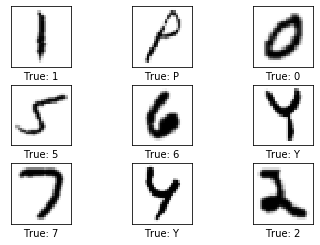

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

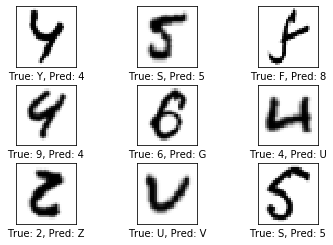

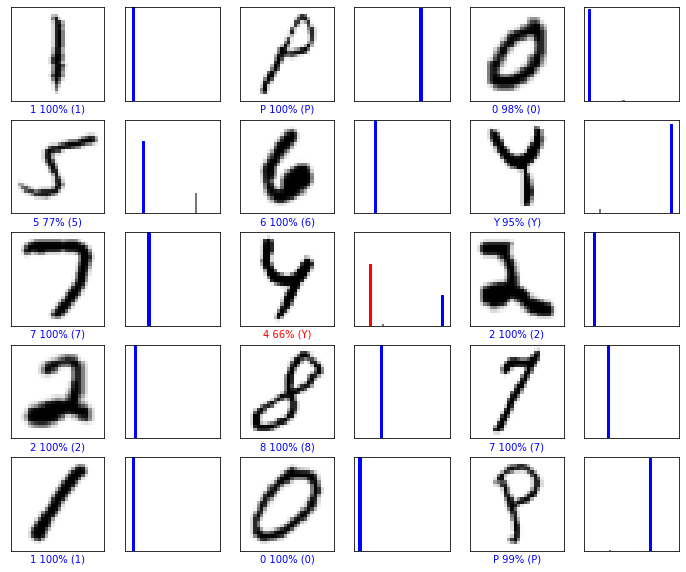

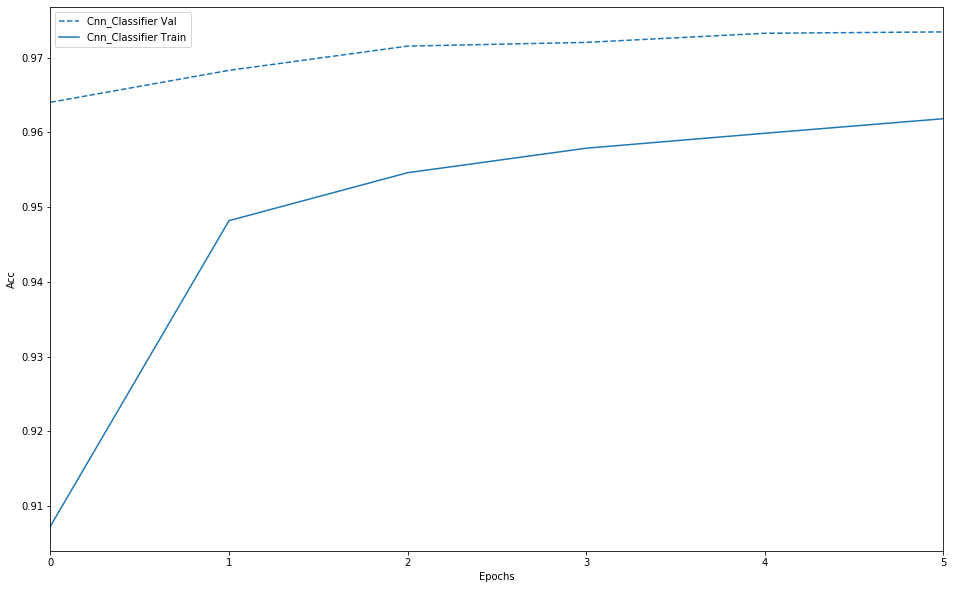

In [40]:
if __name__ == '__main__':
    main()